In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.metrics import confusion_matrix
import pyltr

import data_preprocessing
%matplotlib inline
params = {'axes.labelsize': 14,'axes.titlesize':14, 'text.fontsize': 14, 'legend.fontsize': 14,
          'xtick.labelsize': 13, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 6.5, 4

matplotlib.rcParams.update(params)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
balance_flag = True

In [3]:
#Training file
df=df = pd.read_pickle('cleaned_dataset')

# add column with relevance scores
df['relevance'] = df['booking_bool'] + df['click_bool']

# change relevance column with relevance score (1 if clicked, 5 if booked)
df['relevance'] = df['relevance'].map({0:0, 1:1, 2:5})


In [4]:

# create list of ids in random order
id_list = df.srch_id.unique()
np.random.shuffle(id_list)

# for reproducibility 
np.random.seed(1337)

# training - test fraction is 70/30
id_train = int(len(id_list) * 0.7)
id_val = int(len(id_list) * 0.9)

training_id = id_list[:id_train]
validation_id = id_list[id_train:id_val]

test_id = id_list[id_val:]

# divide dataset in test and training set
train = df.loc[df.srch_id.isin(training_id)]
val = df.loc[df.srch_id.isin(validation_id)]
test = df.loc[df.srch_id.isin(test_id)]

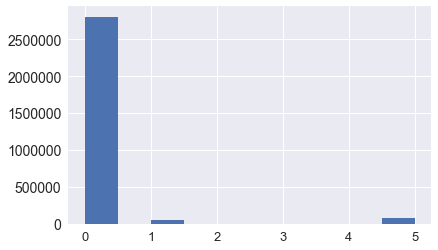

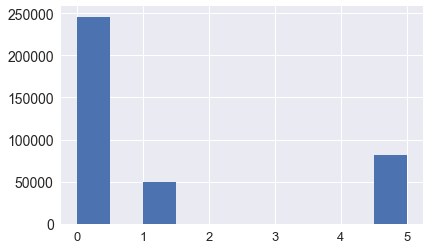

In [5]:
from sklearn.utils import resample

train['relevance'].hist()

plt.show()
def balance_dataset(train):
    
    # Separate majority and minority classes
    df_majority = train[train.relevance==0]
    df_minority = train[train.relevance==5]
    df_minority2 = train[train.relevance==1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0]*3,     # to match minority class
                                     random_state=123) # reproducible results


    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority, df_minority2])

    # Display new class counts
    df_downsampled.relevance.value_counts()

    df_downsampled['relevance'].hist()
    #df_downsampled['relevance'].value_counts()
    train = df_downsampled
    return train

if balance_flag:
    train = balance_dataset(train)

In [6]:
train = train.sort_values('srch_id')

In [7]:
#Efi's code for data cleaning
data = df

In [8]:
##Unorthodox Implementation - vectors or fearures need to be reduced/rearranged

#Select the same features from each dataset
selected_features = ['comp6_rate_percent_diff_signed',
 'comp4_rate_percent_diff_signed',
 'comp8_rate_percent_diff_signed',
 'comp7_rate_percent_diff_signed',
 'star_diff_from_historic_mean',
 'visitor_hist_adr_usd',
 'srch_query_affinity_score',
 'srch_room_count',
 'visitor_hist_starrating',
 'price_diff_from_historic_mean',
 'srch_adults_count',
 'prop_brand_bool',
 'prop_country_id',
 'visitor_location_country_id',
 'prop_starrating',
 'prop_review_score',
 'srch_saturday_night_bool',
 'site_id',
 'srch_length_of_stay',
 'prop_starrating_monot',
 'random_bool',
 'promotion_flag',
 'prop_location_score_mean',
 'orig_destination_distance',
 'srch_children_count',
 'prop_location_score2',
 'prop_id',
 'star_rank']

selected_features = list(set(selected_features))
features_to_keep = ['booking_bool', 'srch_id', 'click_bool', 'prop_id', 'relevance']
all_possible_features = features_to_keep + selected_features
df_to_train = train.ix[:,all_possible_features]
df_to_val = val.ix[:,all_possible_features]
df_to_test = test.ix[:,all_possible_features]



#Since we've created a new variable that combined those two, there's no need in keeping them
df_to_train.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_val.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_test.drop(['booking_bool', 'click_bool'], axis = 1)

#Rearrange the columns because lambdaMART wants the target variable and the IDs in the first and second column respectively
df_to_train = df_to_train[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_val =  df_to_val[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_test =  df_to_test[['relevance', 'srch_id', 'prop_id']+selected_features]


# Downsample majority class

In [10]:
feats = list(df_to_test[selected_features].columns)


In [11]:
#From dataframes to arrays
trrelevance_arr = np.array(df_to_train['relevance'])
trfeature_arr = np.array(df_to_train[selected_features])
trid_arr = np.array(df_to_train.srch_id)

vrelevance_arr = np.array(df_to_val['relevance'])
vfeature_arr = np.array(df_to_val[selected_features])
vid_arr = np.array(df_to_val.srch_id)

terelevance_arr = np.array(df_to_test['relevance'])
tefeature_arr = np.array(df_to_test[selected_features])
teid_arr = np.array(df_to_test.srch_id)

In [12]:
test1 = df_to_train[selected_features]
test1.shape

(377505, 31)

In [13]:
#Choose nDCG as metric (k arbitrary number)
metric = pyltr.metrics.NDCG(k=10)

#Use validation set, stop_after arbitrary number
# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    vfeature_arr, vrelevance_arr, vid_arr, metric=metric, stop_after=250)

In [14]:
vfeature_arr.shape

(839902, 31)

In [ ]:
#Use lambdaMART - have to find the best values for the parametes
n_estimators = 200
model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=n_estimators,
    learning_rate=0.03,
    #max_features=0.5,
    #query_subsample=0.5,
    #max_leaf_nodes=10,
    #min_samples_leaf=64,
    verbose=1
)

model.fit(trfeature_arr, trrelevance_arr, trid_arr, monitor=monitor)

 Iter  Train score    Remaining                           Monitor Output 
    1       0.7331       72.56m      C:      0.2134 B:      0.2134 S:  0


In [ ]:
tepred = model.predict(tefeature_arr)
print('Random ranking:', metric.calc_mean_random(teid_arr, terelevance_arr))
print('Our model:', metric.calc_mean(teid_arr, terelevance_arr, tepred))

#Need to add Search and Property IDs to the output (easy)
tepred

In [ ]:
with open('result_statistics.txt', mode='a+') as f:
    f.write('%s\t%s\t%.2f\t%.2f\t%.2f\t%.5f\t%s\n'%(len(feats), n_estimators, len(df)/100000,len(df_to_train)/100000, len(df_to_test)/100000,metric.calc_mean(teid_arr, terelevance_arr, tepred, balance_flag)) )
    

In [ ]:
import pickle
model_save = pickle.dumps(model)
new_model = pickle.loads(model_save)
